In [466]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.differentiate import jacobian

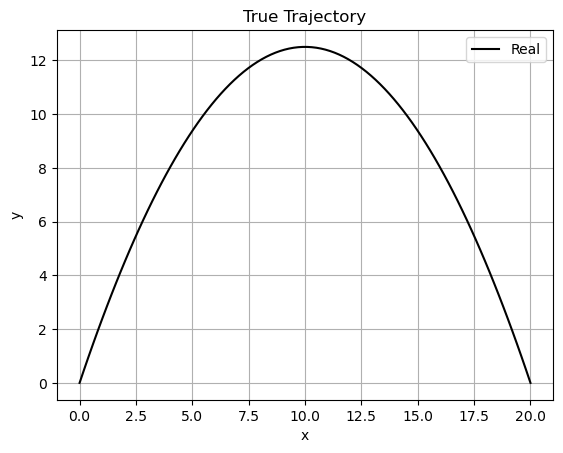

In [467]:
# True trajectory
pts = 100
t = np.linspace(0,10,pts)
dt = t[1] - t[0]
xTrue = t*2
yTrue = 5*t - 0.5*t**2

vxTrue = np.gradient(xTrue,dt)
vyTrue = np.gradient(yTrue,dt)
stateTrue = np.vstack((xTrue,yTrue,vxTrue,vyTrue))

plt.figure(1)
plt.plot(xTrue,yTrue,'k-',label='Real')
plt.xlabel('x')
plt.ylabel('y')
plt.title('True Trajectory')
plt.legend()
plt.grid()
plt.show()

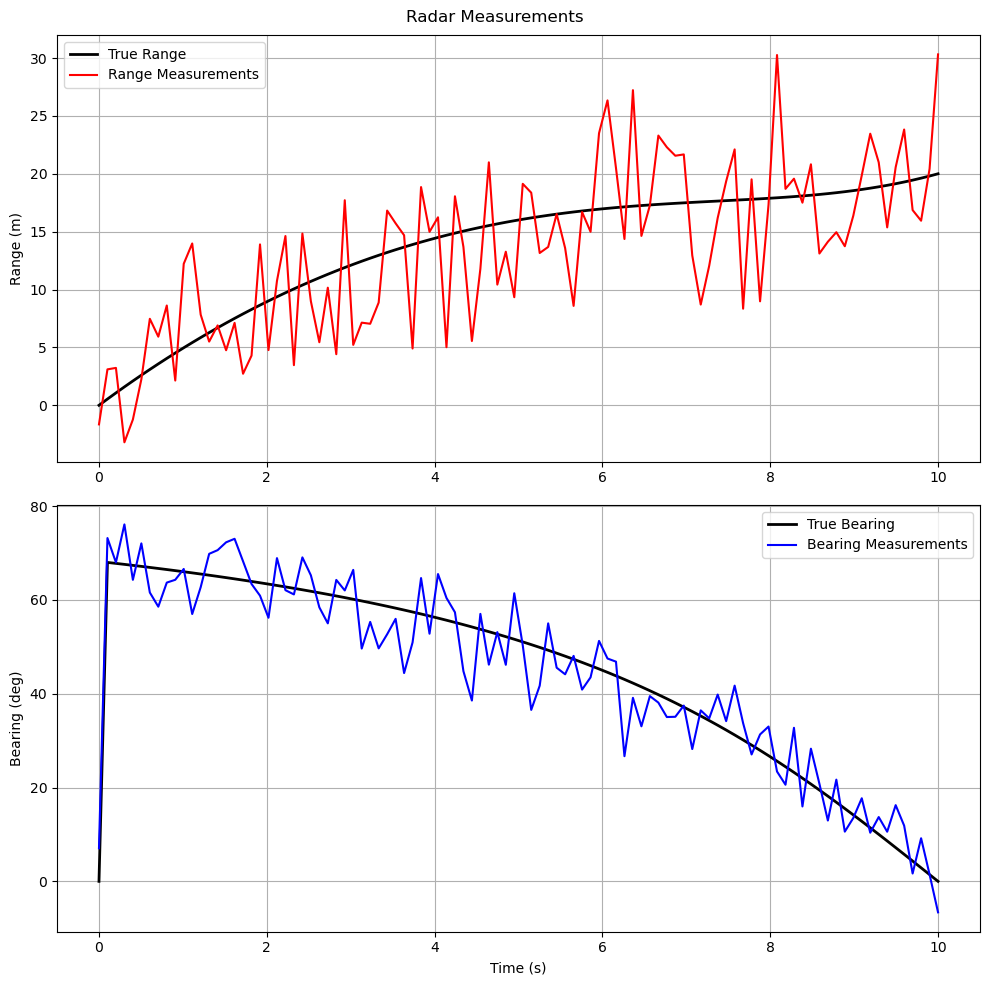

In [468]:
# Radar measurements (range and bearing)
range_error = 5 # 5 meters
bearing_error = 0.1 # 0.1 radians

range_true = np.sqrt(xTrue**2 + yTrue**2) 
bearing_true = np.arctan2(yTrue, xTrue) 

range_measurement = range_true + np.random.normal(0, range_error, size=pts) # Add noise
bearing_measurement = bearing_true + np.random.normal(0, bearing_error, size=pts) # Add noise

plt.figure(2, figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(t, range_true, 'k-', linewidth=2, label='True Range')
plt.plot(t, range_measurement, 'r-', markersize=2, label='Range Measurements')
plt.ylabel('Range (m)')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2) 
plt.plot(t, np.rad2deg(bearing_true), 'k-', linewidth=2, label='True Bearing')
plt.plot(t, np.rad2deg(bearing_measurement), 'b-', markersize=2, label='Bearing Measurements')
plt.ylabel('Bearing (deg)')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)

plt.suptitle('Radar Measurements')
plt.tight_layout()
plt.show()

In [469]:
def f(state): # motion model 
    x, y, vx, vy = state  
    xnew = x + vx*dt
    ynew = y + vy*dt - 0.5*dt**2  
    vxnew = vx  # Constant velocity
    vynew = vy + (-1)*dt  # Constant acceleration in y
    return np.array([xnew, ynew, vxnew, vynew])

def h(state): # Measurement function
    x, y, vx, vy = state
    z1 = np.sqrt(x**2 + y**2) # Range measurement
    z2 = np.arctan2(y, x) # Bearing measurement
    return np.array([z1,z2])

In [470]:
## Extended Kalman Filter Implementation

# Process noise covariance
Q = np.array([[0.1, 0, 0, 0], #x,y,vx,vy,ax,ay
              [0, 0.1, 0, 0],
              [0, 0, 0.5, 0],
              [0, 0, 0, 0.5]])


# Measurement noise covariance
R = np.array([[range_error**2, 0],
              [0, bearing_error**2]])

P = np.eye(4) * 10 # Initial estimate error covariance

r0 = range_measurement[0]
b0 = bearing_measurement[0]
x0 = r0 * np.cos(b0)
y0 = r0 * np.sin(b0)
state = np.array([x0, y0, 0, 0])  # Initial state guess

estimates = [state.copy()]
for i in range(1, pts):

    prev = state.copy() # Store previous state for debugging

    # Prediction step
    state = f(state)
    F = jacobian(f,prev).df # Motion model Jacobian

    P = F @ P @ F.T + Q

    measurement = h(state)
    H = jacobian(h, state).df # Measurement model Jacobian

    # Correct step
    z = np.array([range_measurement[i], bearing_measurement[i]]) # Current measurement
    z[1] = np.arctan2(np.sin(z[1]), np.cos(z[1])) # Normalize angle to [-pi, pi]
    innovation = z - measurement # Measurement residual
    innovation[1] = np.arctan2(np.sin(innovation[1]), np.cos(innovation[1])) # Normalize angle to [-pi, pi]
    
    S = H @ P @ H.T + R # Innovation covariance
    S = S + np.eye(2)*1e-6 # Avoid singularity

    K = P @ H.T @ np.linalg.inv(S) # Kalman Gain
    state = state + K @ innovation # Update state estimate
    P = P - K @ H @ P
    estimates.append(state.copy())

    if i % 100 == 0:
        print(f"Kalman Gain at step {i}: \n{K}\n")

estimates = np.array(estimates)

xestimates = estimates[:,0]
yestimates = estimates[:,1]
range_estimates = np.sqrt(xestimates**2 + yestimates**2)
bearing_estimates = np.arctan2(yestimates, xestimates)

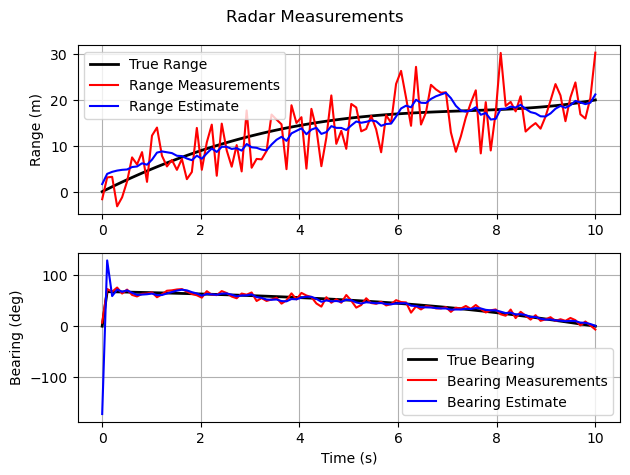

In [471]:
# plt.figure(3, figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(t, range_true, 'k-', linewidth=2, label='True Range')
plt.plot(t, range_measurement, 'r-', markersize=2, label='Range Measurements')
plt.plot(t, range_estimates, 'b-', markersize=2, label='Range Estimate')
plt.ylabel('Range (m)')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2) 
plt.plot(t, np.rad2deg(bearing_true), 'k-', linewidth=2, label='True Bearing')
plt.plot(t, np.rad2deg(bearing_measurement), 'r-', markersize=2, label='Bearing Measurements')
plt.plot(t, np.rad2deg(bearing_estimates), 'b-', markersize=2, label='Bearing Estimate')
plt.ylabel('Bearing (deg)')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)

plt.suptitle('Radar Measurements')
plt.tight_layout()
plt.show()

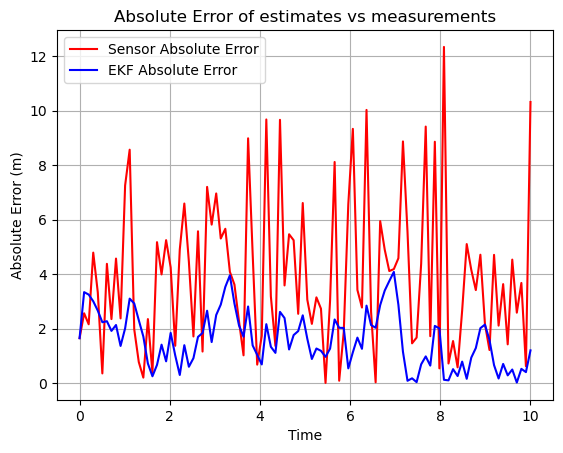

In [472]:
# Comparison of true trajectory, sensor data, and EKF estimates
abs_sensor = np.sqrt((range_measurement - range_true)**2)
abs_ekf = np.sqrt((range_estimates - range_true)**2)
plt.figure(4)
plt.plot(t, abs_sensor, 'r-', label='Sensor Absolute Error')
plt.plot(t, abs_ekf, 'b-', label='EKF Absolute Error')
plt.xlabel('Time')
plt.ylabel('Absolute Error (m)')
plt.title('Absolute Error of estimates vs measurements')
plt.legend()
plt.grid()
plt.show()
